# Zivich (2026): Pooled Logistic Regression for Survival Analysis

In the corresponding pre-print, Zivich et al. propose a novel implementation of estimating equations for causal survival analysis. This example reviews those key results and demonstrates how to use ``ee_plogit``. See the corresponding paper for finer details on the full approach and how it works. This page primarily focuses on how to apply the code (and not the identification assumptions or underlying g-computation algorithm described in the paper).

## Setup

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import delicatessen as deli
from delicatessen import MEstimator
from delicatessen.estimating_equations import ee_plogit
from delicatessen.utilities import inverse_logit, spline, plogit_predict

print("Versions")
print("NumPy:       ", np.__version__)
print("SciPy:       ", sp.__version__)
print("pandas:      ", pd.__version__)
print("Matplotlib:  ", mpl.__version__)
print("Delicatessen:", deli.__version__)

Versions
NumPy:        2.3.5
SciPy:        1.16.3
pandas:       2.3.3
Matplotlib:   3.10.8
Delicatessen: 4.1


## Example 1: Bladder Cancer Time-to-Recurrence

The first example comes from a data set in Collett (2015). The data consists of 86 patients who received either placebo or the chemotherapeutic thiotepa following removal of superficial bladder tumors, with time measured in months. Baseline variables included the initial number of tumors and the diameter (in centimeters) of the largest initial tumor. 

In [2]:
d = pd.read_csv("data/collett.dat", sep=r'\s+',
                names=['patient', 'time', 'delta', 'treat', 'init', 'size'])
d['novel'] = d['treat'] - 1
d['intercept'] = 1

In [3]:
t = np.asarray(d['time'])
y = np.asarray(d['delta'])
W = np.asarray(d[['novel', 'init', 'size', ]])

Here, the parameter of interest was the effect comparing novel to standard treatment on disease-free survival at 59 months (end of follow-up). While treatment was randomized, both number of tumors and tumor diameter are adjusted for in this illustration. Here, we will review how pooled logistic regression can be used for these types of survival analyses.

### Pooled Logistic Regression

First, examine how a pooled logistic regression model can be fit to the data. Here, time is modeled using disjoint indicators which is handled automatically by ``ee_pooled_logistic`` by default.

In [4]:
# Number of unique event times (for specifying the initial values)
unique_event_times = list(np.unique(d.loc[d['delta'] == 1, 'time']))
params_plr = len(unique_event_times)

In [5]:
def psi_plogit(theta):
    ee_plog = ee_plogit(theta, t=t, delta=y, X=W)
    return ee_plog

In [6]:
inits = ([0., ]*W.shape[1] +          # Coefs for baseline vars
         [-4., ] +                    # Coef for intercept
         [0., ]*(params_plr - 1))  # Coefs for time terms
estr = MEstimator(psi_plogit, init=inits)
estr.estimate()
estr.print_results(subset=[x for x in range(W.shape[1])])

              Estimation Method: M-estimator
--------------------------------------------------------------
No. Observations:          86 | No. Parameters:             24
Solving algorithm:         lm | Max Iterations:           5000
Solving tolerance:      1e-09 | Allow P-Inverse:             1
Derivative Method:     approx | Deriv Approx:            1e-09
Small N Correction:      None | Distribution:           Z-stat
   Theta   StdErr  Z-score      LCL      UCL  P-value  S-value 
--------------------------------------------------------------
   -0.55     0.33    -1.66    -1.19     0.10     0.10     3.37 
    0.26     0.08     3.15     0.10     0.42     0.00     9.28 
    0.07     0.09     0.79    -0.11     0.26     0.43     1.22 


Here, we examine the 3 parameters corresponding to the baseline covariates. As detailed elsewhere, these coefficients can be interpreted as approximating the hazard ratio. Specifically, the hazard of recurrence among those on the novel drug is $\exp(-0.55) = 0.58$ that of those on placebo, conditional on tumor size and count. 

Rather than model time non-parametrically, one can also use parametric specifications for how the discrete-time hazard of the event changes over time. As in the paper, we consider the use of splines to model time. Here, time was modeled restricted quadratic splines with knots at 10, 20, 30, and 40 months.

In [7]:
# Creating time design matrix
t_steps = np.asarray(range(1, np.max(d['time']+1)))
intercept = np.ones(t_steps.shape)[:, None]
time_splines = spline(t_steps, knots=[10, 20, 30, 40],
                      power=2, restricted=True, normalized=False)
s_matrix = np.concatenate([intercept, t_steps[:, None], time_splines], axis=1)

In [8]:
def psi_plogit(theta):
    ee_plog = ee_plogit(theta, t=t, delta=y, X=W, S=s_matrix)
    return ee_plog

In [9]:
inits = ([0., ]*W.shape[1] +          # Coefs for baseline vars
         [-4., ] +                    # Coef for intercept
         [0., 0., 0., 0.])            # Coefs for time terms
estr = MEstimator(psi_plogit, init=inits)
estr.estimate()
estr.print_results(subset=[x for x in range(W.shape[1])])

              Estimation Method: M-estimator
--------------------------------------------------------------
No. Observations:          86 | No. Parameters:              8
Solving algorithm:         lm | Max Iterations:           5000
Solving tolerance:      1e-09 | Allow P-Inverse:             1
Derivative Method:     approx | Deriv Approx:            1e-09
Small N Correction:      None | Distribution:           Z-stat
   Theta   StdErr  Z-score      LCL      UCL  P-value  S-value 
--------------------------------------------------------------
   -0.54     0.32    -1.68    -1.16     0.09     0.09     3.41 
    0.25     0.08     3.30     0.10     0.40     0.00     9.99 
    0.07     0.09     0.78    -0.11     0.26     0.43     1.21 


Here, we see the coefficients for the covariates are largely the same. While this is the case in this example, this may not always be true (especially when relying on more restrictive functional forms for time). 

### G-computation

As also detailed elsewhere, the hazard ratio has some major challenges for interpretation, including non-collapsibility. Now we show how to transform these pooled logistic regression results into marginal risk functions, which are easier to interpret and avoid some of these challenges. We will use a g-computation algorithm here. Briefly, we will fit a pooled logistic regression model, then we will use those coefficients to project what would have happened if everyone as given thiotepa (placebo). Both tumor count and tumor size were modeled as linear relationships. For flexibility, we will fit pooled logistic regression models stratified by treatment. This approach to modeling does not rely on a proportional hazards assumption for the treatment (unlike the previous approach).

In [10]:
# Data under the plans of interest (all-treat, all-placebo)
d1 = d.copy()
d1['novel'] = 1
d0 = d.copy()
d0['novel'] = 0

In [11]:
a = np.asarray(d['novel'])
t = np.asarray(d['time'])
y = np.asarray(d['delta'])
W = np.asarray(d[['init', 'size', ]])

In [12]:
# Counting up events to define number of parameters later
event_times = [0, ] + list(np.unique(d.loc[d['delta'] == 1, 'time'])) + [59, ]
event_times_a1 = list(np.unique(d.loc[(d['delta'] == 1) & (d['novel'] == 1), 'time']))
event_times_a0 = list(np.unique(d.loc[(d['delta'] == 1) & (d['novel'] == 0), 'time']))
params_rd = len(event_times)
params_plr_a1 = len(event_times_a1)
params_plr_a0 = len(event_times_a0)

In [13]:
def psi_rd(theta):
    # Extracting parameters
    rds = theta[:params_rd]
    idPLR = params_rd + W.shape[1] + params_plr_a1
    beta1 = theta[params_rd: idPLR]
    beta0 = theta[idPLR:]

    # Nuisance models
    ee_plog1 = ee_plogit(beta1, t=t, delta=y, X=W, unique_times=event_times_a1)
    ee_plog1 = ee_plog1 * (a == 1)[None, :]

    ee_plog0 = ee_plogit(beta0, t=t, delta=y, X=W, unique_times=event_times_a0)
    ee_plog0 = ee_plog0 * (a == 0)[None, :]

    # Predictions to get risk differences
    risk1 = plogit_predict(theta=beta1, delta=y, t=t, X=W,
                           times_to_predict=event_times, 
                           measure='risk', 
                           unique_times=event_times_a1)
    risk0 = plogit_predict(theta=beta0, delta=y, t=t, X=W,
                           times_to_predict=event_times, 
                           measure='risk', 
                           unique_times=event_times_a0)
    ee_rd = (risk1 - risk0) - np.asarray(rds)[:, None]

    # Returning stacked estimating equations
    return np.vstack([ee_rd, ee_plog1, ee_plog0])

In [14]:
inits = ([0., ]*params_rd
         + [0., ]*W.shape[1] + [-4., ] + [0., ]*(params_plr_a1 - 1)
         + [0., ]*W.shape[1] + [-4., ] + [0., ]*(params_plr_a0 - 1))
estr = MEstimator(psi_rd, init=inits)
estr.estimate()

We can then examine the table for the causal risk difference at 59 months.

In [15]:
estr.print_results(subset=[params_rd-1])

              Estimation Method: M-estimator
--------------------------------------------------------------
No. Observations:          86 | No. Parameters:             54
Solving algorithm:         lm | Max Iterations:           5000
Solving tolerance:      1e-09 | Allow P-Inverse:             1
Derivative Method:     approx | Deriv Approx:            1e-09
Small N Correction:      None | Distribution:           Z-stat
   Theta   StdErr  Z-score      LCL      UCL  P-value  S-value 
--------------------------------------------------------------
   -0.19     0.12    -1.63    -0.42     0.04     0.10     3.28 


Perhaps more informative is to examine a plot of the results. In this plot, inference is implicitly for the underlying causal risk difference *function*, so rather than confidence *intervals* the confidence *bands* are presented. The confidence bands can be straightforwardly computed using `delicatessen`.

In [16]:
cb = estr.confidence_bands(method='supt', subset=[x for x in range(1, params_rd)], seed=7777)

In [17]:
# Formatting RD results for figure
rd = estr.theta[:params_rd]
rd_ci = estr.confidence_intervals()[:params_rd, :]
rd_results = pd.DataFrame()
rd_results['time'] = event_times
rd_results['rd'] = rd
rd_results['lcb'] = [0.,] + list(cb[:, 0])
rd_results['ucb'] = [0.,] + list(cb[:, 1])

Text(0, 0.5, 'Risk Difference')

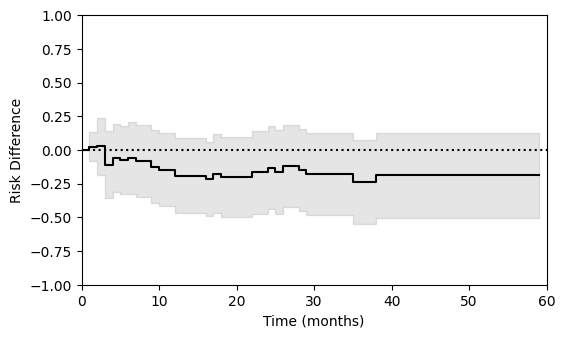

In [18]:
fig, ax = plt.subplots(figsize=[6, 3.5])
ax.axhline(y=0, linestyle=':', color='k')
ax.fill_between(rd_results['time'], rd_results['lcb'], rd_results['ucb'], color='k', alpha=0.1, step='post')
ax.step(rd_results['time'], rd_results['rd'], color='k', where='post')
ax.set_xlim([0, 60])
ax.set_ylim([-1, 1])
ax.set_xlabel("Time (months)")
ax.set_ylabel("Risk Difference")

The same process can also be done when modeling time using splines. The following code illustrates this process

In [19]:
# Creating time design matrix
t_steps = np.asarray(range(1, 60))
intercept = np.ones(t_steps.shape)[:, None]
time_splines = spline(t_steps, knots=[10, 20, 30, 40],
                      power=2, restricted=True, normalized=False)
s_matrix = np.concatenate([intercept, t_steps[:, None], time_splines], axis=1)
tp_intervals = list(range(0, 60))
params_rd = len(tp_intervals)

In [20]:
def psi_rd(theta):
    # Extracting parameters
    risks = theta[:params_rd]
    idPLRM = params_rd + 7
    beta1 = theta[params_rd:idPLRM]
    beta0 = theta[idPLRM:]

    # Nuisance models
    ee_plog1 = ee_plogit(beta1, t=t, delta=y, X=W, S=s_matrix)
    ee_plog1 = ee_plog1 * (a == 1)[None, :]
    ee_plog0 = ee_plogit(beta0, t=t, delta=y, X=W, S=s_matrix)
    ee_plog0 = ee_plog0 * (a == 0)[None, :]

    # Predictions to get risk differences
    risk1 = plogit_predict(theta=beta1, t=t, delta=y, X=W, S=s_matrix,
                           times_to_predict=tp_intervals, measure='risk')
    risk0 = plogit_predict(theta=beta0, t=t, delta=y, X=W, S=s_matrix,
                           times_to_predict=tp_intervals, measure='risk')
    ee_rd = (risk1 - risk0) - np.asarray(risks)[:, None]

    # Returning stacked estimating equations
    return np.vstack([ee_rd, ee_plog1, ee_plog0])

In [21]:
inits = [0., ]*params_rd + [0., 0., -4., ] + [0., ]*4 + [0., 0., -4., ] + [0., ]*4
estr = MEstimator(psi_rd, init=inits)
estr.estimate()
cb = estr.confidence_bands(method='supt', subset=[x for x in range(1, params_rd)], seed=7777)

In [22]:
rd_results = pd.DataFrame()
rd_results['time'] = tp_intervals
rd_results['rd'] = estr.theta[:params_rd]
rd_results['lcl'] = [0.,] + list(cb[:, 0])
rd_results['ucl'] = [0.,] + list(cb[:, 1])

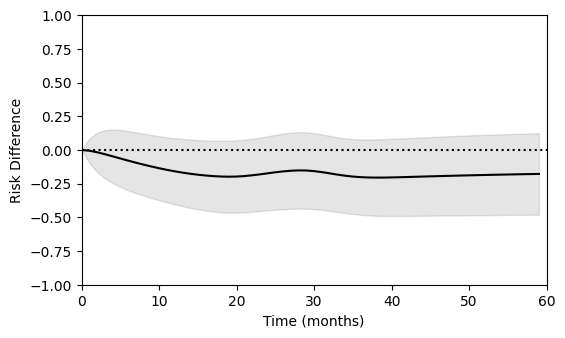

In [23]:
fig, ax = plt.subplots(figsize=[6, 3.5])
ax.axhline(y=0, linestyle=':', color='k')
ax.fill_between(rd_results['time'], rd_results['lcl'], rd_results['ucl'], color='k', alpha=0.1)
ax.plot(rd_results['time'], rd_results['rd'], color='k')
ax.set_xlim([0, 60])
ax.set_ylim([-1, 1])
ax.set_xlabel("Time (months)")
ax.set_ylabel("Risk Difference")
plt.show()

The results between the two approaches are largely the same. These examples highlight how pooled logistic regression can be used to flexibily conduct causal survival analyses. Importantly, the estimating equation approach taken here can substantially reduce run-times and avoids reliance on the bootstrap for inference. Further details on this general approach and the benefits of estimating equations can be found in the following references.

## References

Abbott RD. (1985). Logistic regression in survival analysis. *American Journal of Epidemiology*, 121(3), 465-471.

D'Agostino RB, Lee ML, Belanger AJ, Cupples LA, Anderson K, & Kannel WB. (1990). Relation of pooled logistic regression to time dependent Cox regression analysis: the Framingham Heart Study. *Statistics in Medicine*, 9(12), 1501-1515.

Dumas E, & Stensrud MJ. (2025). How hazard ratios can mislead and why it matters in practice *European Journal of Epidemiology*, 40(6), 603-609.

Hernán MA. (2010). The hazards of hazard ratios. *Epidemiology*, 21(1), 13-15.

Zivich PN, Cole SR, Shook-Sa BE, DeMonte JB, & Edwards JK. (2025). Estimating equations for survival analysis with pooled logistic regression. *arXiv:2504.13291*

Zivich PN, Klose M, DeMonte JB, Shook-Sa BE, Cole SR, & Edwards JK. (2026). An Improved Pooled Logistic Regression Implementation. *Epidemiology*, In-Press.